## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt, dates
import seaborn as sns
from scipy.stats import norm, t, ttest_ind, shapiro
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
# составим таблицу сводных показателей:
pivot = data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': (lambda x: x.sum()/1e6)
}).rename(columns={'user_id': 'users_count', 'purchase': 'purchases', 'price': 'sum'})

display(pivot)

,users_count,purchases,sum
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
users_a = set(data[data['group'] == 'A']['user_id'])
users_b = set(data[data['group'] == 'B']['user_id'])
users_intersection = users_a.intersection(users_b)

print('Уникальных пользователей, попавших в обе группы - {}'.format(len(users_intersection)))

Уникальных пользователей, попавших в обе группы - 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in users_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

![image.png](attachment:95f235d2-6323-4799-bf69-697fc57f727b.png)
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
# составим таблицу сводных показателей:
pivot = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

display(pivot)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


✍️ Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

## **Выводы: Из сводной таблицы видно, что количество посещений на сайт практичеси идентичны, и отличаются лишь на сотые доли процента. Можно однозначно назвать выборки сбалансированными.**

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
pivot['conversion'] = round(pivot['count_purchases'] / pivot['count_visits'] * 100, 2)
pivot['mean_check'] = round(pivot['sum_price'] / pivot['count_purchases'])

display(pivot)

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

## **Выводы: Сравнивая показатели групп, можно сказать, что конверсия в группе А немного выше, зато средний чек в группе B намного превосходит показатель группы А. На первый взгляд кажется, что вариант В эффективнее, так как разница в конверсиях очень мала, и может лежать в пределах статистической погрешности, а вот различия в размере среднего чека очень ощутимы (это от 8% до 9%).**

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
# формируем сводную таблицу:
pivot_tours = pd.pivot_table(
    updated_data[updated_data['price'] > 0],
    values='purchase',
    index='group',
    columns='price',
    aggfunc='count'
)

display(pivot_tours)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

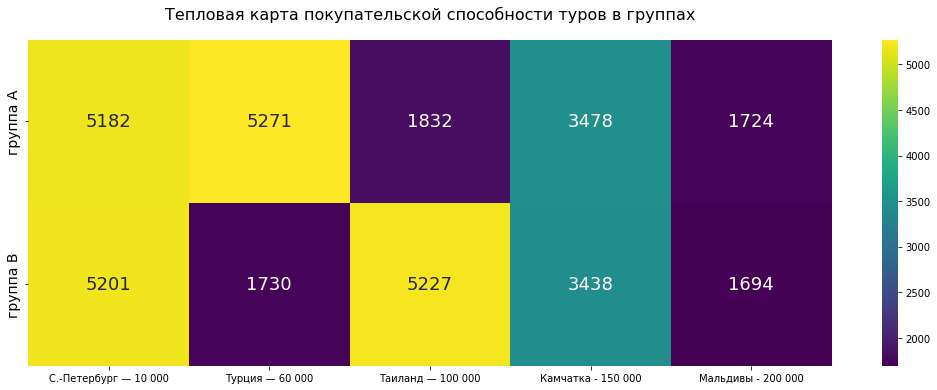

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize = (18, 6))
tours_on_price = sns.heatmap(
    data=pivot_tours,
    annot=True,
    annot_kws={"fontsize":18},
    xticklabels=['С.-Петербург — 10 000', 'Турция — 60 000', 'Таиланд — 100 000', 'Камчатка - 150 000', 'Мальдивы - 200 000'],
    fmt='.0f',
    cmap='viridis'
)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_yticklabels(['группа A', 'группа B'], fontsize=14)
tours_on_price.set_title('Тепловая карта покупательской способности туров в группах', fontsize=16, pad=20);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

## **Выводы: По турам в Санкт-Петербург, на Камчатку и на Мальдивы покупательская способность в обоих группах практически совпадает. А вот на туры в Турцию и Тайланд отличаются диаметрально противоположно. В группе А туры в Турцию продаются почти в 3 раза больше, чем в Тайлайд, а в группе В с точностью до наоборот. Можно с уверенность сказать, что именно данное различие сильно влияет на общую выручку по группам.**

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
# сгруппируем данные по дням:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

# добавим информацию о ежедневной конверсии и ежедневном среднем чеке:
daily_data['conversion'] = round(daily_data['count_purchases'] / daily_data['count_visits'] * 100, 2)
daily_data['mean_check'] = round(daily_data['sum_price'] / daily_data['count_purchases'])

display(daily_data.head())

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
# вычисляем кумулятивное количество посещений страницы:
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивное количество покупок:
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок:
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
# вычисляем кумулятивную конверсию и кумулятивный средний чек:
daily_data['cum_conversion'] = round(daily_data['cum_count_purchases']/daily_data['cum_count_visits'] * 100, 2)
daily_data['cum_mean_check'] = round(daily_data['cum_sum_price']/daily_data['cum_count_purchases'])

print('Кумулятивная конверсия 20 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-20')][['group', 'cum_conversion']].round(2))
print('Кумулятивная конверсия 12 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-12')][['group', 'cum_mean_check']].round())

Кумулятивная конверсия 20 января 2020 года:


,group,cum_conversion
36,A,11.98
37,B,11.90


Кумулятивная конверсия 12 января 2020 года:


,group,cum_mean_check
20,A,81492.0
21,B,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

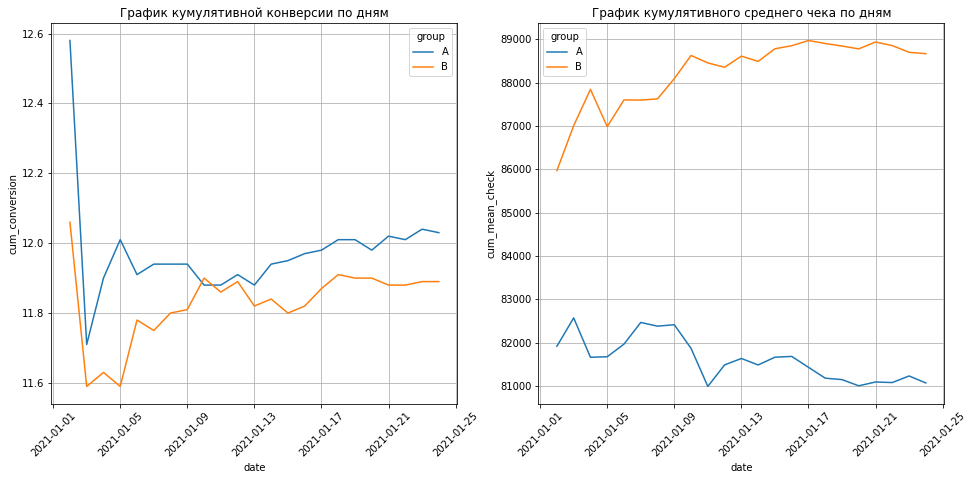

In [14]:
fig, axes= plt.subplots(1, 2, figsize=(16, 7))
# строим график для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])
# строим график для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])

axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График кумулятивного среднего чека по дням')
axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)
axes[0].grid(True);
axes[1].grid(True);

## **Вывод: На графиках хорошо видно, что в начале данные подвержены сильным колебаниям, но со временем они выравниваются в почти горизонтальныве прямые и метрики выравниваются. Исследование можно считать завершенным.**
## **Конверсия в группе А стабильно выше конверсии в группе В.**
## **Средний чек же в группе В довольно выше, чем в группе А.**

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
# считаем количество успехов и наблюдений в каждой из групп
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

# поскольку конверсия — это пропорция, для проверки гипотезы равенства пропорций воспользуемся z-критерием для пропорций:
print('\nДля проверки гипотезы равенства пропорций воспользуемся z-критерием для пропорций:')

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

#вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], 
    nobs=converted_piv['count'],
    alternative='larger'
)

print('p-value: ', round(p_value, 2))

#сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,sum,count
group,,
A,17487,145307
B,17290,145381



Для проверки гипотезы равенства пропорций воспользуемся z-критерием для пропорций:
p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

## **Вывод: Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике - статистически не значима. То есть разницы между двумя вариантами страницы сайта по метрике конверсии покупки нет. Для конверсии покупки оба варианта одинаково эффективны.**

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


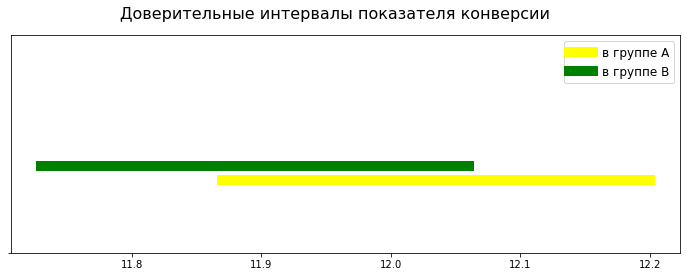

In [16]:
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']
conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(), # размер выборки
b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(), b_data['user_id'].count()] # размеры выборок групп А и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()] # выборочная пропорция групп A и B

# визуализируем полученные результаты:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
plt.suptitle('Доверительные интервалы показателя конверсии', size=16)
x1, x2, y1, y2 = conf_interval_a, conf_interval_b, [1, 1], [1.2, 1.2]
plt.plot(x1, y1, label='в группе А', c='yellow', linewidth=10)
plt.plot(x2, y2, label='в группе B', c='green', linewidth=10)
plt.legend(fontsize=12)
plt.ylim(0, 3)
ax.set_yticks(range(0, 100, 100))
ax.set_yticklabels('')

# строим доверительный интервал для разности
diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

## **Вывод: Данные доверительные интервалы показателя конверсии имеют пересечение, т.е. существует вероятность, что истинное значение конверсии в обеих группах может совпадать.**
## **Построенный доверительный интервал разницы конверсий с 95 %-ой надёжностью говорит нам, что эта разница лежит в интервале от -0.38 % до 0.09 %, т.е. может быть как положительной, так и отрицательной.**
## **Отсюда делаем вывод, что статистической разницы в конверсии между вариантами А и B не существует, т.е. они являются равнозначными по данной метрике.**

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [17]:
print('Воспользуемся критерием нормальности Шапиро-Уилка, который является надёжным и пригоден для небольших выборок:\n')

# нулевая и альтернативная гипотезы и уровень значимости:
H0 = 'Распределения в обеих группах нормальные.'
H1 = 'Распределение в одной или обеих группах отлично от нормального.'
alpha = 0.05

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data[daily_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу: {}".format(H0))

Воспользуемся критерием нормальности Шапиро-Уилка, который является надёжным и пригоден для небольших выборок:

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу: Распределения в обеих группах нормальные.


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [18]:
print('Для сравнения двух небольших независимых нормально распределенных выборок хорошо подходит T-тест:\n')

# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны.'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B.'
alpha = 0.05 #уровень значимости

#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data[daily_data['group'] == 'A']['mean_check'],
    b=daily_data[daily_data['group'] == 'B']['mean_check'],
    alternative='less'
)

print('p-value:', round(results.pvalue, 2))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу: {}".format(H0))

Для сравнения двух небольших независимых нормально распределенных выборок хорошо подходит T-тест:

p-value: 0.0
Отвергаем нулевую гипотезу: Ежедневные средние чеки в группах А и B равны.
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

## **Вывод: Поскольку значение p-value находится очень близко к нулю, то и вероятность принятия нулевой гипотезы ничтожно мала и значительно меньше заданного уровня значимости.**
## **Статистическая разница между ежедневными средними чеками в группах есть.**

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)



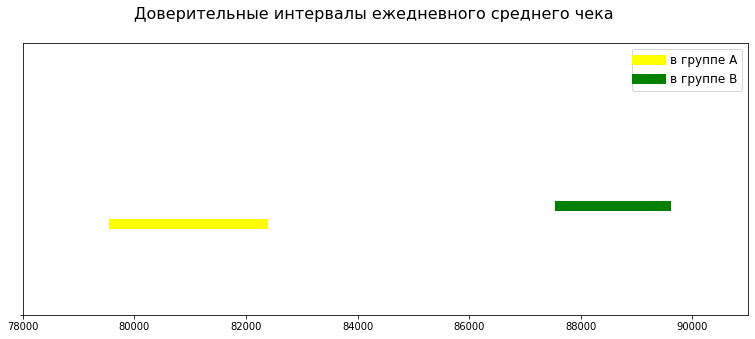

In [19]:
def mean_check_conf_interval(sample: pd.Series, gamma=0.95):
    k = sample.count() -1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * sample.std()/(sample.count() ** 0.5) # погрешность
    lower_bound = sample.mean() - eps # левая (нижняя) граница
    upper_bound = sample.mean() + eps # правая (верхняя) граница
    return round(lower_bound), round(upper_bound)

# построим 95%-ый доверительный интервал для среднего чека в каждой группе:
conf_interval_a = mean_check_conf_interval(daily_data[daily_data['group'] == 'A']['mean_check'])
conf_interval_b = mean_check_conf_interval(daily_data[daily_data['group'] == 'B']['mean_check'])

print('Доверительный интервал для среднего чека группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для среднего чека группы B: {}\n'.format(conf_interval_b))

# визуализируем полученные результаты:
fig, ax = plt.subplots(1, 1, figsize = (13, 5))
plt.suptitle('Доверительные интервалы ежедневного среднего чека', size=16)
x1, x2, y1, y2 = conf_interval_a, conf_interval_b, [1, 1], [1.2, 1.2]
plt.plot(x1, y1, label='в группе А', c='yellow', linewidth=10)
plt.plot(x2, y2, label='в группе B', c='green', linewidth=10)
plt.legend(fontsize=12)
plt.xlim(78000, 91000)
plt.ylim(0, 3)
ax.set_yticks(range(0, 100, 100))
ax.set_yticklabels('');

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

## **Вывод: Доверительные интервалы не имеют пересечения. Не существует вероятности, что истинное значение среднего чека в обеих группах может совпадать. Отсюда делаем вывод, что между вариантами А и B существует значимая разница по данной метрике.**

# ⭐️ **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

## **Общий вывод по результатам нашего исследования может быть следующим: вариант В более эффективен!**
### Разница по показателям ежедневного среднего чека существенна и статистически значима. В отличие от разницы по показателю конверсии, которую можно определить как одинаковую в обеих группах.
### Показатель ежедневного среднего чека в группе В выше за счет увеличения доли покупок более дорогих туров в Таиланд, и снижения интереса к более дешевым турам в Турцию.
### Если предположить, что в выборках нет случайных перекосов, то можно делать однозначное заключение: **второй вариант посадочной страницы официального сайта компании более эффективен!**